In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle

from xgboost import XGBRegressor
from IPython.display import clear_output
import torch
import torch.nn as nn
from torch.utils.data import Dataset
torch.manual_seed(20210614)
import itertools
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.models import Model
import time
from sklearn.gaussian_process import GaussianProcessRegressor

### In this notebook we compare performance of different NN structures on our experimental data
**As the NN prediction depends on the initialization, we send bootstrap of the train-test splits to each structure and show the mean of `MSE` and `R^2` within error bars which can be `standard error=std/sqrt(n_booststrap-1)` or 1std.**

In [4]:
address = '/Volumes/GoogleDrive-117271245802891063093/My Drive/PostDoc/MLFE/ML-NRC-paper1/Data/'

df_0 = pd.read_csv(address + 'Param0_2width.csv')
df_1 = pd.read_csv(address +'Param1_2width.csv')
df_2 = pd.read_csv(address +'Param2_2width.csv')
df_3 = pd.read_csv(address +'Param3_2width.csv')
df_4 = pd.read_csv(address +'Param4_2width.csv')

df1 = pd.concat([df_0, df_1, df_2, df_3, df_4], axis = 0, ignore_index = True)
print(df1.keys())
df1 = shuffle(df1, random_state=20210614)

# ###------- normalizing data 
normalizer = MinMaxScaler()
df_norm = normalizer.fit_transform(df1)

df = pd.DataFrame(df_norm, columns=df1.columns )


Index(['Frequency', 'Speed', 'Amplitude', 'Passes', 'Focal_Position', 'Depth',
       'Top_width', 'Bot_width'],
      dtype='object')


In [3]:
def NN_MultiLayer(Xtrain, Y_train, Xtest, Y_test, n_layers, layer_nodes):
#     n_outputs = Y_train.shape[1]           # in case we want to predict multiple parameters 
    tensorflow.random.set_seed(20210614)   # to make initialization reproducible 

    input = Input(shape=(4,))
    if n_layers >= 1 : 
        x = Dense(layer_nodes[0], activation='relu')(input)
    elif n_layers >= 2 :
        x = Dense(layer_nodes[1], activation='relu')(x)
    elif n_layers >= 3 :
        x = Dense(layer_nodes[2], activation='relu')(x)
    # x = Dense(16, activation='relu')(x)    # uncomment in case more layers are needed
    output = Dense(1)(x)
    model = Model(inputs=input, outputs=output)
    model.compile(optimizer='adam', loss='mse')

    model.fit(Xtrain, (Y_train) , epochs=500, batch_size=128 ,verbose=0)
    pred = model.predict(Xtest)

    error = (mean_squared_error(pred, Y_test)).round(3)
    Rsquare = (r2_score(pred, Y_test)).round(3)
    return error , Rsquare

In [66]:
NN_structures = {'/16/': [16], 
                '/64/': [64],
                '/128/': [128],
                '/32/16/':[32, 16],
                '/64/32/': [64, 32],
                '/128/64/': [128, 64],
                '/64/32/16/':[64, 32, 16],
                '/128/64/32/':[128, 64, 32]}

n_bootstrap = 100
for key in NN_structures:
    losses = []
    R2es = []
    t = time.process_time()
    for i in range(n_bootstrap):
        Train, Test = train_test_split(df, test_size = 0.20)
        loss, R2 = NN_MultiLayer(Train.iloc[:,1:5], np.array(Train.iloc[:,5]), 
                                 Test.iloc[:,1:5], np.array(Test.iloc[:,5]),
                                 len(NN_structures[key]), NN_structures[key]
                                )
        losses.append(loss)
        R2es.append(R2)
    
    elapsed_time = time.process_time() - t  

    print('\nmean_MSE for ',key ,' is: ', np.mean(np.array(losses))*100,\
          '&&&&& std_MSE is: ', (np.array(losses)).std(ddof=1)*100)
    print('mean_R2 for ',key ,'is: ', np.mean(np.array(R2es))*100, ' %', 
         '&&&&& std_R2 is: ', (np.array(R2es)).std(ddof=1)*100)
    print('time: ',round(elapsed_time/n_bootstrap, 6), '\n*********')



mean_MSE for  /16/  is:  1.5600000000000003 &&&&& std_MSE is:  0.5725290155828003
mean_R2 for  /16/ is:  58.855000000000004  % &&&&& std_R2 is:  13.832131738132508
time:  1.134986 
*********

mean_MSE for  /64/  is:  0.79 &&&&& std_MSE is:  0.26137289353275367
mean_R2 for  /64/ is:  83.41499999999999  % &&&&& std_R2 is:  7.238150025349965
time:  1.144887 
*********

mean_MSE for  /128/  is:  0.9200000000000004 &&&&& std_MSE is:  0.3533300231556298
mean_R2 for  /128/ is:  83.585  % &&&&& std_R2 is:  6.056859964666423
time:  1.17874 
*********

mean_MSE for  /32/16/  is:  1.1450000000000002 &&&&& std_MSE is:  0.4198684004354346
mean_R2 for  /32/16/ is:  72.02  % &&&&& std_R2 is:  18.33023386878112
time:  1.122132 
*********

mean_MSE for  /64/32/  is:  1.0999999999999999 &&&&& std_MSE is:  0.5231483637805969
mean_R2 for  /64/32/ is:  77.17500000000001  % &&&&& std_R2 is:  11.034294626061826
time:  1.146761 
*********

mean_MSE for  /128/64/  is:  0.7850000000000001 &&&&& std_MSE is:  0.

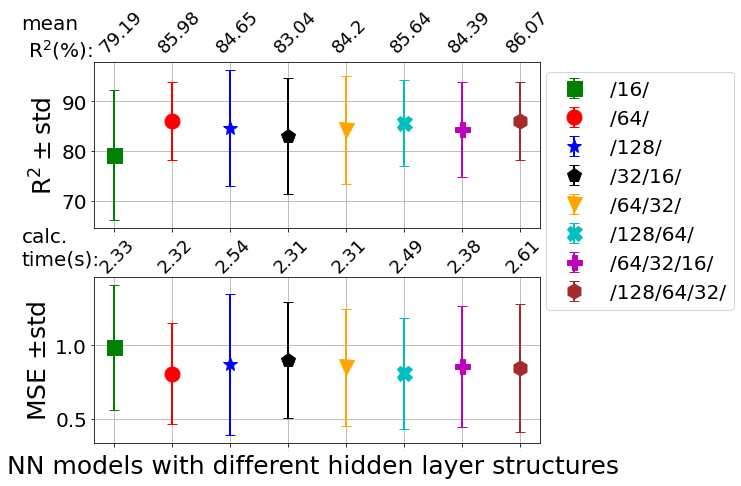

In [44]:
fig = plt.figure(figsize=(8,7))

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
plt.subplots_adjust(hspace=0.3)
colors = ["g","r", "b", "k", "orange", "c", "m", 'brown']
markers = ["s", "o", "*", "p","v" ,"X", "P", "h", "D", "d",  "^", "<", ">"]
j = -1
for key in results:
    j += 1
   
    ax1.errorbar(j, results[key][2],
            yerr= results[key][3],
             capsize=5,c = colors[j%8], fmt=markers[j%13],
            ms=15, lw =2, label = key)
    
    ax2.errorbar(j, results[key][0],
        yerr= results[key][1],
             capsize=5,c = colors[j%8], fmt=markers[j%13],
            ms=15, lw =2, label = key)
    ax1.text(j-0.3,100,str(round(results[key][2],2)),fontsize= 18, rotation=45)
    ax2.text(j-0.3,1.5
             ,str(round(results[key][4],2)),fontsize= 18, rotation=45)
    
ax1.legend(bbox_to_anchor=(0.99, 1.0), fontsize=20)

ax1.grid()
ax2.grid()

ax1.text(-1.6,99,'mean\n R$^2$(%):',fontsize= 20, rotation=0)
ax2.text(-1.6,1.55,'calc.\ntime(s):',fontsize= 20, rotation=0)

ax1.set_ylabel('R$^2 \pm $std', fontsize=25)
ax2.set_ylabel('MSE $\pm $std', fontsize=25)
ax2.set_xlabel('NN models with different hidden layer structures ', fontsize=25)
ax1.tick_params(axis='x', labelsize=0)
ax2.tick_params(axis='x', labelsize=0)
ax1.tick_params(axis='y', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
plt.savefig('Graphs/NN_structures_std.png',bbox_inches='tight')

plt.show()

## In case of rush we can plot saved results instead of running the above codes 

In [77]:
"""'columns ': ['mean_MSE', 'std_MSE', 'mean_R2', 'std_R2', 'calc. time']"""
NN_MSE_R2 = {
#     '/8/': [1.25, 0.513, 72.923, 17.284, 2.304833],
                '/16/': [1.052, 0.550, 79.054, 12.463, 2.291251], 
#                 '/32/': [0.786, 0.323, 84.428, 9.654, 2.248626],
                '/64/': [0.866, 0.422, 84.668, 8.342, 2.243049],
                '/128/': [0.802, 0.446, 86.515, 8.165, 2.426772],
                '/256/': [0.753, 0.362, 86.353, 8.820, 2.521705],
#                 '/16/8/': [1.021, 0.494, 79.732, 13.744, 2.20445],
                '/32/16/':[0.915, 0.437, 83.765, 9.690, 2.18843],
                '/64/32/':[0.687, 0.381, 87.442, 8.103, 2.213456],
                '/128/64/': [0.881, 0.447, 85.443, 9.090, 2.390168],
#                 '/256/128/': [0.842, 0.451, 85.421, 8.721, 2.574917],
                '/32/16/8/': [0.884, 0.391, 82.291, 11.615, 2.288785],
                '/64/32/16/': [0.764, 0.344, 86.418, 7.404, 2.283328],
                '/128/64/32/': [0.844, 0.426, 85.939, 8.641, 2.486498]}


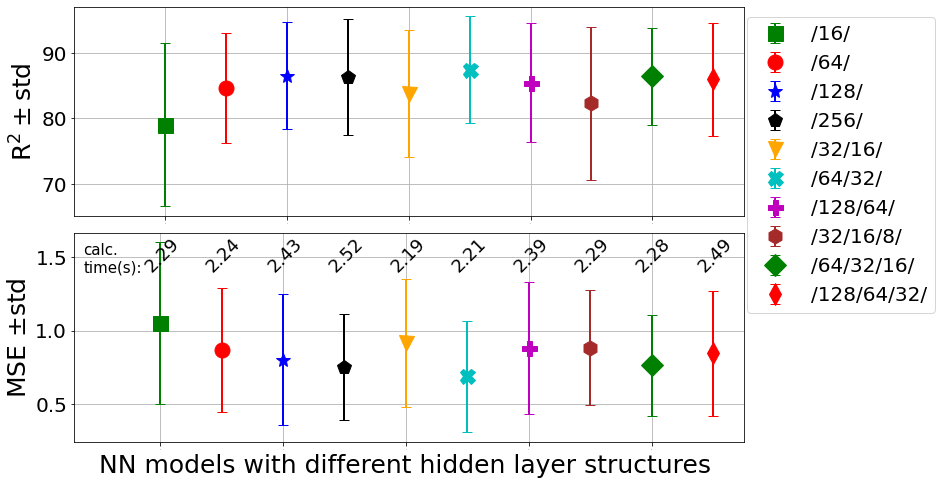

In [88]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
plt.subplots_adjust(hspace=0.08)
colors = ["g","r", "b", "k", "orange", "c", "m", 'brown']
markers = ["s", "o", "*", "p","v" ,"X", "P", "h", "D", "d",  "^", "<", ">"]
j = -1
for key in NN_MSE_R2:
    j += 1
   
    ax1.errorbar(j, NN_MSE_R2[key][2],
            yerr= NN_MSE_R2[key][3],
             capsize=5,c = colors[j%8], fmt=markers[j%13],
            ms=15, lw =2, label = key)
    
    ax2.errorbar(j, NN_MSE_R2[key][0],
        yerr= NN_MSE_R2[key][1],
             capsize=5,c = colors[j%8], fmt=markers[j%13],
            ms=15, lw =2, label = key)
    
    ax2.text(j-0.3,1.4,str(round(NN_MSE_R2[key][4],2)),fontsize= 18, rotation=45)
ax1.legend(bbox_to_anchor=(0.99, 1.0), fontsize=20)
ax1.grid()
ax2.grid()
ax1.set_xlim(-1.5, 9.5)
ax2.text(-1.25,1.4,'calc.\ntime(s):',fontsize= 15, rotation=0)
ax2.set_xlim(-1.4, 9.5)
ax1.set_ylabel('R$^2 \pm $std', fontsize=25)
ax2.set_ylabel('MSE $\pm $std', fontsize=25)
ax2.set_xlabel('NN models with different hidden layer structures ', fontsize=25)
ax1.tick_params(axis='x', labelsize=0)
ax2.tick_params(axis='x', labelsize=0)
ax1.tick_params(axis='y', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
plt.savefig('Graphs/NN_structures_std.png',bbox_inches='tight')

plt.show()